In [1]:
import xarray
import spires
import numpy as np
import matplotlib.pyplot as plt

In [2]:
interpolator = spires.LutInterpolator(lut_file='../tests/data/lut_sentinel2b_b2to12_3um_dust.mat')
bands = interpolator.bands
solar_angles = interpolator.solar_angles
dust_concentrations = interpolator.dust_concentrations
grain_sizes = interpolator.grain_sizes
reflectances = interpolator.reflectances

In [3]:
r = xarray.load_dataset('../tests/data/sentinel_r.nc')
r0 = xarray.load_dataset('../tests/data/sentinel_r0.nc')
x0 = np.array([0.5, 0.05, 10, 250])

In [4]:
r

<xarray.Dataset> Size: 1GB
Dimensions:               (time: 2, y: 921, x: 1347, band: 9, detector: 7,
                           x_angles: 23, y_angles: 23)
Coordinates:
  * band                  (band) <U3 108B 'B2' 'B3' 'B4' ... 'B11' 'B12' 'B8'
  * detector              (detector) <U2 56B '10' '11' '12' '6' '7' '8' '9'
  * time                  (time) datetime64[ns] 16B 2024-02-25T18:43:39.02400...
  * x                     (x) float64 11kB 3.146e+05 3.146e+05 ... 3.28e+05
  * x_angles              (x_angles) float64 184B 3e+05 3.05e+05 ... 4.1e+05
  * y                     (y) float64 7kB 4.171e+06 4.171e+06 ... 4.162e+06
  * y_angles              (y_angles) float64 184B 4.2e+06 4.195e+06 ... 4.09e+06
Data variables: (12/13)
    AOT                   (time, y, x) float32 10MB 0.039 0.039 ... 0.038 0.038
    CLD                   (time, y, x) float64 20MB 0.0 0.0 0.0 ... 50.0 50.0
    SCL                   (time, y, x) float64 20MB 11.0 11.0 11.0 ... 8.0 8.0
    SNW                   (time, y, x) float64 20MB 100.0 100.0 ... 0.0 0.0
    WVP                   (time, y, x) float32 10MB 0.258 0.262 ... 0.398 0.398
    reflectance           (time, band, y, x) float32 89MB 0.5558 ... 0.8392
    ...                    ...
    sun_azimuth_grid      (time, x, y) float32 10MB 155.6 155.6 ... 155.1 155.1
    sun_zenith_grid       (time, x, y) float32 10MB 50.02 50.02 ... 48.0 48.0
    viewing_azimuth_grid  (time, band, detector, x, y) float32 625MB nan ... nan
    viewing_zenith_grid   (time, band, detector, x, y) float32 625MB nan ... nan
    ndvi                  (time, y, x) float32 10MB 0.05591 0.2145 ... -0.01871
    ndsi                  (time, y, x) float32 10MB 0.8584 0.797 ... 0.493
Attributes: (12/84)
    AOT_QUANTIFICATION_VALUE:              1000.0
    AOT_QUANTIFICATION_VALUE_UNIT:         none
    AOT_RETRIEVAL_ACCURACY:                0.0
    AOT_RETRIEVAL_METHOD:                  SEN2COR_DDV
    BOA_QUANTIFICATION_VALUE:              10000
    BOA_QUANTIFICATION_VALUE_UNIT:         none
    ...                                    ...
    viewing_zenith_mean_B5:                5.55509677905887
    viewing_zenith_mean_B6:                5.59921210713732
    viewing_zenith_mean_B7:                5.64492094942767
    viewing_zenith_mean_B8:                5.4248694111022
    viewing_zenith_mean_B8A:               5.69907913532304
    viewing_zenith_mean_B9:                5.80704603536241

In [5]:
date = '2024-02-25'
ts = r.sel(time=date).squeeze().drop_vars('time')

In [8]:
spectra_targets = ts['reflectance'].transpose('y', 'x', 'band')
spectra_backgrounds = r0['reflectance'].transpose('y', 'x', 'band')
obs_solar_angles = ts['sun_zenith_grid'].transpose('y', 'x')
spectrum_shade = np.zeros_like(spectra_targets[0,0,:])
spectra_targets.shape
results = np.empty((spectra_targets.y.size, spectra_targets.x.size, 4), dtype=np.double)

In [30]:
np.zeros(spectra_targets.band.size, dtype=np.double)

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [26]:
spectrum_shade

array([0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [25]:
spectra_targets.y.size
spectra_targets.x.size

1347

In [9]:
spectrum_shade

array([0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [10]:
spectra_targets.values[0, 0,:]

array([0.5558    , 0.5458    , 0.5327    , 0.5654239 , 0.72348046,
       0.65982926, 0.04159382, 0.02848547, 0.5958    ], dtype=float32)

In [11]:
spectra_targets.values.flatten()[0:9]

array([0.5558    , 0.5458    , 0.5327    , 0.5654239 , 0.72348046,
       0.65982926, 0.04159382, 0.02848547, 0.5958    ], dtype=float32)

In [12]:
spires.core.invert_array2d(spectra_backgrounds=spectra_backgrounds, 
                           spectra_targets=spectra_targets, 
                           spectrum_shade=spectrum_shade, 
                           obs_solar_angles=obs_solar_angles, 
                           bands=bands, solar_angles=solar_angles, dust_concentrations=dust_concentrations, grain_sizes=grain_sizes, lut=reflectances, 
                           results=results, 
                           max_eval=100, 
                           x0=x0, 
                           algorithm=2)

In [17]:
results[:,:,1].max()

1.0

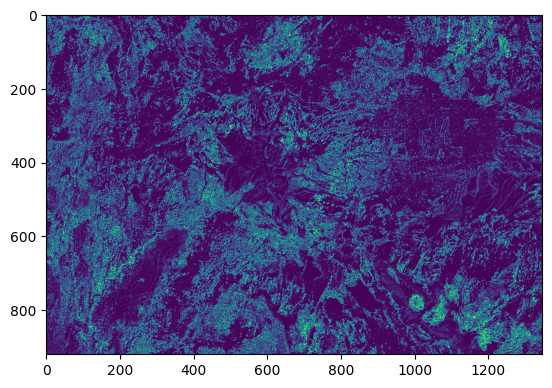

In [21]:
plt.imshow(results[:,:, 2])

In [ ]:
%%time
results = spires.speedy_invert_array1d(spectra_targets=spectra_targets.values,
                                       spectra_backgrounds=spectra_backgrounds.values,
                                       obs_solar_angles=obs_solar_angles.values,
                                       interpolator=interpolator)

### 